In [1]:
import time
from absl import logging
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import tqdm
import os

In [2]:
%run 'yolov3_tf2.ipynb'

In [3]:
%run 'utils.ipynb'

In [4]:
%run 'metrics_evaluation.ipynb'

In [5]:
classFile = './Data/classes.txt'
weights = './checkpoint/yolov3_train_43.tf'
size = 416
tfrecord =  None#'./Data/audi_test.tfrecord'
num_classes = 14
class_names = [c.strip() for c in open(classFile).readlines()]
cur_dir = os.getcwd()

# Create a dictionary describing the features.
image_feature_description = {
    'image/encoded': tf.io.FixedLenFeature([], tf.string),
    'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
    'image/object/class/text': tf.io.VarLenFeature(tf.string),
    'image/filename': tf.io.FixedLenFeature([], tf.string),
}

In [6]:
def _parse_image_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

def detect(image):    
    yolo = YoloV3(classes=num_classes)

    yolo.load_weights(weights).expect_partial()
    logging.info('weights loaded')

    if tfrecord:
        img_raw = image
    else:
        img_raw = tf.image.decode_image(open(image, 'rb').read(), channels=3)

    img = tf.expand_dims(img_raw, 0)
    img = transform_images(img, size)

    t1 = time.time()
    boxes, scores, classes, nums = yolo(img)
    t2 = time.time()
    logging.info('time: {}'.format(t2 - t1))

    img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
        
    wh = np.flip(img.shape[0:2])
    return boxes, scores, classes, nums, wh

In [7]:
def detect_inputTFRecords():
    idx = 0
    obsDf = pd.DataFrame(columns=['id','imgFile', 'x1', 'x2', 'y1', 'y2','class','score'])

    raw_image_dataset = tf.data.TFRecordDataset(tfrecord)
    parsed_image_dataset = raw_image_dataset.map(_parse_image_function)

    for image_features in tqdm.tqdm(parsed_image_dataset):
        image_raw = tf.image.decode_jpeg(image_features['image/encoded'], channels=3)
        image_raw = tf.image.resize(image_raw, (size, size))
        
        imgFile = image_features['image/filename'].numpy().decode('utf8')
        imgId = imgFile.split('/')[-1].split('_')[-1].split('.')[0].lstrip('0')
        outputs = detect(image_raw)
        boxes, objectness, classes, nums, wh = outputs
        boxes, objectness, classes, nums = boxes[0], objectness[0], classes[0], nums[0]

        for i in range(nums):
            x1y1 = tuple((np.array(boxes[i][0:2]) * wh).astype(np.int32))
            x2y2 = tuple((np.array(boxes[i][2:4]) * wh).astype(np.int32))
            obsDf.loc[idx] = pd.Series({'id':imgId,'imgFile': imgFile, 'x1': x1y1[0], 
                                 'x2': x2y2[0], 'y1':x1y1[1] , 'y2': x2y2[1],
                                 'class':class_names[int(classes[i])],
                                 'score':round(float(objectness[i]),3) })
            idx += 1
    return obsDf

In [ ]:
test_result = detect_inputTFRecords()

195it [1:50:56, 61.00s/it]

In [8]:
test_dataset = pd.read_csv('data/test.csv', index_col=0)
test_dataset.head(3)

,id,imgFile,jsonFile
1192,29293,/Data/Audi_dataset/20180810_142822/camera/cam_...,/Data/Audi_dataset/20180810_142822/label3D/cam...
5374,51273,/Data/Audi_dataset/20181008_095521/camera/cam_...,/Data/Audi_dataset/20181008_095521/label3D/cam...
4723,38484,/Data/Audi_dataset/20180925_135056/camera/cam_...,/Data/Audi_dataset/20180925_135056/label3D/cam...


In [9]:
def detect_inputImages():
    idx = 0
    obsDf = pd.DataFrame(columns=['id','imgFile', 'x1', 'x2', 'y1', 'y2','class','score'])
    
    for key, row in tqdm.tqdm(test_dataset.iterrows()):
        outputs = detect(cur_dir+row['imgFile'])
        boxes, objectness, classes, nums, wh = outputs
        boxes, objectness, classes, nums = boxes[0], objectness[0], classes[0], nums[0]

        for i in range(nums):
            x1y1 = tuple((np.array(boxes[i][0:2]) * wh).astype(np.int32))
            x2y2 = tuple((np.array(boxes[i][2:4]) * wh).astype(np.int32))
            obsDf.loc[idx] = pd.Series({'id':row['id'],'imgFile': row['imgFile'], 'x1': x1y1[0], 
                                 'x2': x2y2[0], 'y1':x1y1[1] , 'y2': x2y2[1],
                                 'class':class_names[int(classes[i])],
                                 'score':round(float(objectness[i]),3) })
            idx += 1 
    return obsDf

In [10]:
test_result = detect_inputImages()

76it [17:53, 26.34s/it]


In [11]:
test_result.to_csv('./Data/detection.csv')

In [12]:
d1 = pd.read_csv('./Data/test_detection.csv', index_col=0)
d1.shape

(1249, 8)

In [13]:
d2 = pd.read_csv('./Data/detection.csv', index_col=0)
d = pd.concat([d1,d2])
d.shape

(1328, 8)

In [14]:
d.sort_values(['id','class','x1'],ascending=True).to_csv('./Data/test_detection.csv')

In [15]:
a = pd.read_csv('Data/audi_converted.csv', index_col=0)
arr = d1.id.unique()
gt_obs = a[a.id.isin(arr)]
gt_obs.sort_values(['id','class','x1'],ascending=True).to_csv('Data/test_groundTruth.csv')
gt_obs.shape
#a.x1 = np.where(a.x1 < 0, 0, a.x1)
#a.y1 = np.where(a.y1 < 0, 0, a.y1)
#a.x2 = np.where(a.x2 < 0, 0, a.x2)
#a.y2 = np.where(a.y2 < 0, 0, a.y2)

#a.x1 = np.where(a.x1/a.width > 1, a.width, a.x1)
#a.y1 = np.where(a.y1/a.height > 1, a.height, a.y1)
#a.x2 = np.where(a.x2/a.width > 1, a.width, a.x2)
#a.y2 = np.where(a.y2/a.height > 1, a.height, a.y2)
#a.to_csv('Data/audi_groundTruth.csv')

(2747, 11)

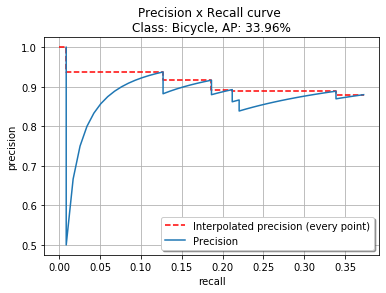

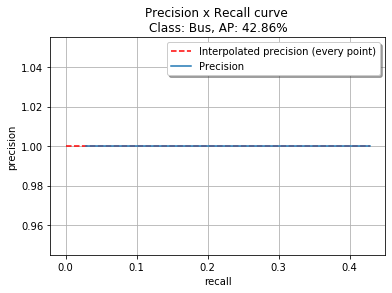

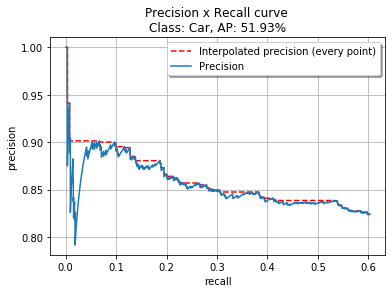

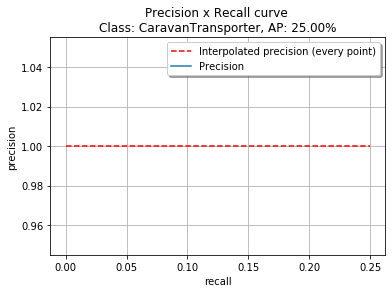

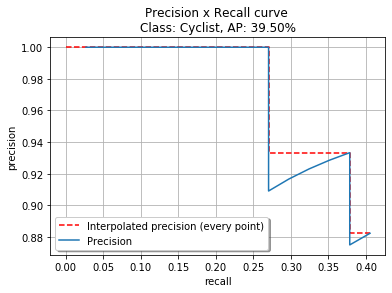

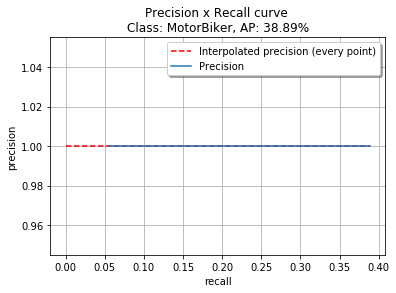

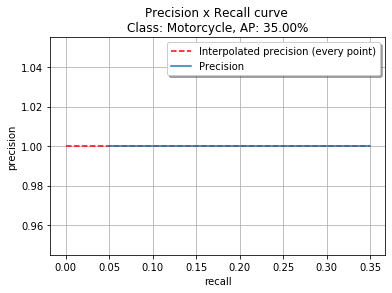

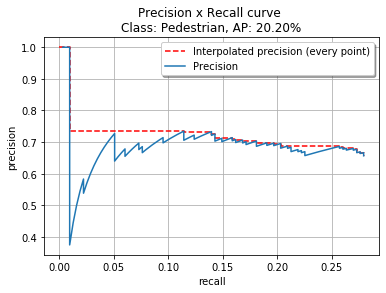

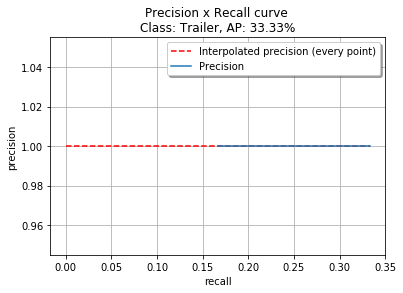

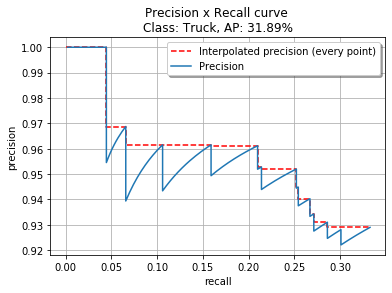

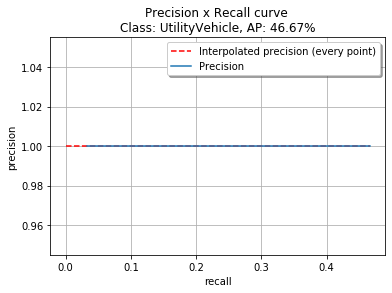

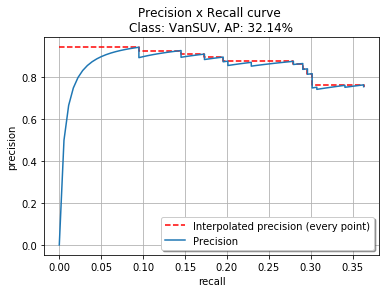

AP: 33.96% (Bicycle)
AP: 42.86% (Bus)
AP: 51.93% (Car)
AP: 25.00% (CaravanTransporter)
AP: 39.50% (Cyclist)
AP: 38.89% (MotorBiker)
AP: 35.00% (Motorcycle)
AP: 20.20% (Pedestrian)
AP: 33.33% (Trailer)
AP: 31.89% (Truck)
AP: 46.67% (UtilityVehicle)
AP: 32.14% (VanSUV)
mAP: 35.95%


14

In [16]:
iouThreshold = 0.4
savePath= cur_dir +'/results/'
gtPath = 'Data/test_groundTruth.csv'
detPath = 'Data/test_detection.csv'
# Get groundtruth boxes
allBoundingBoxes, allClasses = getBoundingBoxes(True, gtPath = gtPath)
# Get detected boxes
allBoundingBoxes, allClasses = getBoundingBoxes(False, 
                                                detPath = detPath, 
                                                allBoundingBoxes = allBoundingBoxes, 
                                                allClasses = allClasses)
allClasses.sort()
evaluator = Evaluator()
acc_AP = 0
validClasses = 0

# Plot Precision x Recall curve
detections = evaluator.PlotPrecisionRecallCurve(
    allBoundingBoxes,  # Object containing all bounding boxes (ground truths and detections)
    IOUThreshold=iouThreshold,  # IOU threshold
    showAP=True,  # Show Average Precision in the title of the plot
    showInterpolatedPrecision=True,  # Don't plot the interpolated precision curve
    savePath=savePath)

f = open(os.path.join(savePath, 'results.txt'), 'w')
f.write('Object Detection Metrics\n')
f.write('Average Precision (AP), Precision and Recall per class:')

# each detection is a class
for metricsPerClass in detections:

    # Get metric values per each class
    cl = metricsPerClass['class']
    ap = metricsPerClass['AP']
    precision = metricsPerClass['precision']
    recall = metricsPerClass['recall']
    totalPositives = metricsPerClass['total positives']
    total_TP = metricsPerClass['total TP']
    total_FP = metricsPerClass['total FP']

    if totalPositives > 0:
        validClasses = validClasses + 1
        acc_AP = acc_AP + ap
        prec = ['%.2f' % p for p in precision]
        rec = ['%.2f' % r for r in recall]
        ap_str = "{0:.2f}%".format(ap * 100)
        print('AP: %s (%s)' % (ap_str, cl))
        f.write('\n\nClass: %s' % cl)
        f.write('\nAP: %s' % ap_str)
        f.write('\nPrecision: %s' % prec)
        f.write('\nRecall: %s' % rec)

mAP = acc_AP / validClasses
mAP_str = "{0:.2f}%".format(mAP * 100)
print('mAP: %s' % mAP_str)
f.write('\n\n\nmAP: %s' % mAP_str)

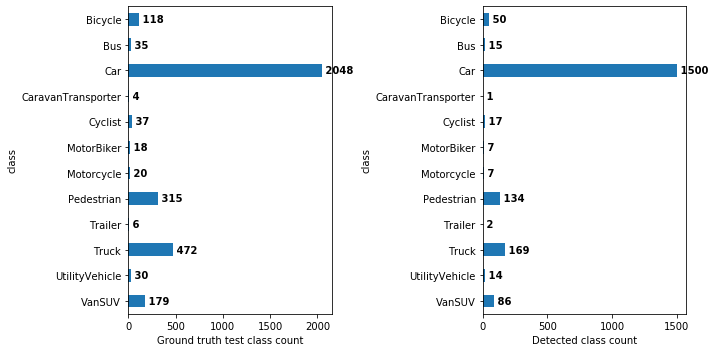

In [17]:
dtDf = pd.read_csv('Data/test_detection.csv', index_col=0)
gtDf = pd.read_csv('Data/test_groundTruth.csv', index_col=0)
figure, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5))
s1 = gtDf.groupby(['class']).size().sort_index(ascending=False)
s1.plot(kind='barh', ax=ax[0])
[ax[0].text(v, i, " "+str(v), va='center', fontweight='bold') for i, v in enumerate(s1)];
_ = ax[0].set_xlabel('Ground truth test class count')
s2 = dtDf.groupby(['class']).size().sort_index(ascending=False)
s2.plot(kind='barh', ax=ax[1])
[ax[1].text(v, i, " "+str(v), va='center', fontweight='bold') for i, v in enumerate(s2)];
_ = ax[1].set_xlabel('Detected class count')
_ = plt.tight_layout()

In [18]:
s1 = pd.DataFrame(gtDf.groupby(['class']).size().reset_index())
s2 = pd.DataFrame(dtDf.groupby(['class']).size().reset_index())
s1 = pd.merge(s1,s2,on=['class'])#,columns=['class','gt'])#.stack(['class'])
s1.columns=['class','groundTruth','detection']
s1['percentage'] = ((s1['detection']/s1['groundTruth']) * 100)
s1 = s1.sort_values(['percentage'], ascending=False)
s1

,class,groundTruth,detection,percentage
2,Car,2048,1500,73.242188
11,VanSUV,179,86,48.044693
10,UtilityVehicle,30,14,46.666667
4,Cyclist,37,17,45.945946
1,Bus,35,15,42.857143
7,Pedestrian,315,134,42.539683
0,Bicycle,118,50,42.372881
5,MotorBiker,18,7,38.888889
9,Truck,472,169,35.805085
6,Motorcycle,20,7,35.000000


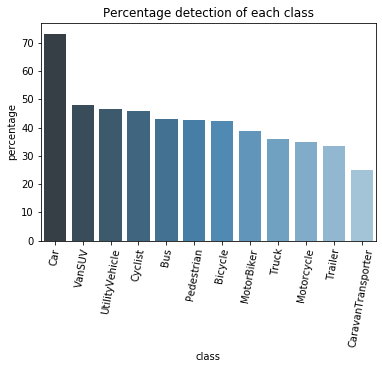

In [19]:
import seaborn as sns
_ = sns.barplot(x=s1['class'],y=s1['percentage'], palette='Blues_d')
_ = plt.xticks(rotation=80)
_ = plt.title('Percentage detection of each class')

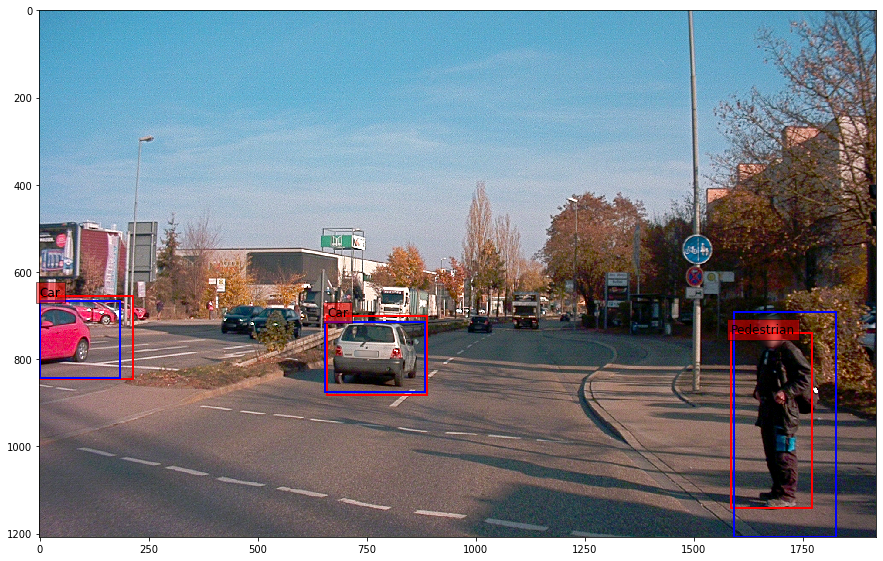

In [37]:
testDf = pd.read_csv('Data/test_detection.csv', index_col=0)
cur_dir = os.getcwd()
s1 = testDf[testDf.imgFile.str.contains('20181107132730_camera_frontcenter_000002800.png')]
img = plt.imread(cur_dir+s1['imgFile'].iloc[0])
figure, ax = plt.subplots(1, figsize=(15,15))
for key, row in s1.iterrows():
    topleft_x = row['x1']
    topleft_y = row['y1']
    bottom_right_x = row['x2']
    bottom_right_y = row['y2']
    rect1 = plt.Rectangle((topleft_x,topleft_y),(bottom_right_x-topleft_x),(bottom_right_y-topleft_y), 
                         edgecolor='r', facecolor='none', linewidth=2)
    _ = ax.add_patch(rect1)
    plt.text(topleft_x, topleft_y, row['class'], fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

audiDf = pd.read_csv('Data/test_groundTruth.csv', index_col=0)
s2 = audiDf[audiDf.imageFile.str.contains('20181107132730_camera_frontcenter_000002800.png')]
for key, row in s2.iterrows():
    topleft_x = row['x1']
    topleft_y = row['y1']
    bottom_right_x = row['x2']
    bottom_right_y = row['y2']
    rect1 = plt.Rectangle((topleft_x,topleft_y),(bottom_right_x-topleft_x),(bottom_right_y-topleft_y), 
                         edgecolor='b', facecolor='none', linewidth=2)
    _ = ax.add_patch(rect1)
    #plt.text(topleft_x, topleft_y, row['class'], fontsize=12, bbox=dict(facecolor='red', alpha=0.5))
_ = plt.imshow(img)